#### Montar pasta do Google Drive ####

In [59]:
# from google.colab import drive
# drive.mount('/content/drive')

#### Imports e pip ####

In [163]:
!pip install transformers
!pip install imbalanced-learn
!pip install pandas
!pip install nltk
!pip install mlxtend

     ---------------------------------------- 1.3/1.3 MB 4.5 MB/s eta 0:00:00


In [281]:
import pandas as pd
import nltk
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_predict
from sklearn.model_selection import cross_validate
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import GradientBoostingClassifier
from imblearn.under_sampling import RandomUnderSampler
from sklearn.svm import SVC
from sklearn.pipeline import Pipeline
from sklearn import svm
from sklearn import metrics
from matplotlib import pyplot
from scipy.stats import loguniform
from IPython.display import display

from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
import string
import re

In [62]:
# termos muito frequentes que não tem relevância nos dados. São palavras que possuem apenas significado sintático dentro da sentença, porém não trazem informações relevantes sobre o seu sentido.
nltk.download('stopwords')
# RSLP Stemmer (Removedor de Sufixos da Lingua Portuguesa)
nltk.download('rslp')
# punkt é um tokenizer 
nltk.download('punkt')
# dicionário de léxicos (conjunto de vocabulários de determinado idioma) e hierarquia de termos
nltk.download('wordnet')
nltk.download('omw-1.4')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\wills\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package rslp to
[nltk_data]     C:\Users\wills\AppData\Roaming\nltk_data...
[nltk_data]   Package rslp is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\wills\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\wills\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     C:\Users\wills\AppData\Roaming\nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


True

#### Carregar os dados nos dataframes ####

In [63]:
df_teste = pd.read_csv('../dataset/teste.csv', sep=';', names=('texto', 'emocao'), encoding='utf-8', header=None)
df_treino = pd.read_csv('../dataset/treino.csv', sep=';', names=('texto', 'emocao'), encoding='utf-8', header=None)
df_validacao = pd.read_csv('../dataset/validacao.csv', sep=';', names=('texto', 'emocao'), encoding='utf-8', header=None)
df = pd.concat([df_treino, df_teste, df_validacao])

#### Análise dos dados (tamanho dataset, valores para emoção, dados nulos/NaN)

In [64]:
df.count()

texto     20004
emocao    19995
dtype: int64

In [65]:
df.head(3)

,texto,emocao
0,não me senti humilhado,tristeza
1,posso passar de me sentindo tão sem esperança ...,tristeza
2,estou pegando um minuto para postar me sinto g...,raiva


<AxesSubplot:>

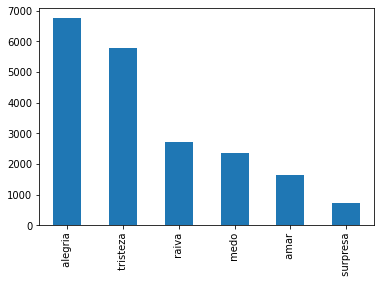

In [66]:
%matplotlib inline
df['emocao'].value_counts().plot(kind='bar')

#### Feature Engineer:

* Análise dos dados (tamanho dataset, valores para emoção, dados nulos/NaN)
* Remover valores nulos/NAN
* Remover linhas duplicadas

In [67]:
df.isna().sum()

texto     0
emocao    9
dtype: int64

In [68]:
df = df.dropna()

In [69]:
df.isna().sum()

texto     0
emocao    0
dtype: int64

In [70]:
df.count()

texto     19995
emocao    19995
dtype: int64

In [71]:
df = df.drop_duplicates(['texto'])

In [72]:
df.count()

texto     19918
emocao    19918
dtype: int64

#### Defini funções para pre processamento

In [73]:
pontuacao = list(string.punctuation)

In [74]:
def exclui_palavras_irrelevantes(texto):
    stops = set(stopwords.words('portuguese') + pontuacao)
    palavras = [i for i in texto.split() if not i in stops]
    return (" ".join(palavras))

In [75]:
def exclui_radicais(texto):
    stemmer = nltk.stem.RSLPStemmer()
    palavras = []
    for w in texto.split():
        palavras.append(stemmer.stem(w))
    return (" ".join(palavras))

In [76]:
def exclui_pontuacao(texto):
    palavras = [i for i in texto if not i in pontuacao]
    return ("".join(palavras))

In [268]:
def lemmatization(instancia):
    wordnet_lemmatizer = WordNetLemmatizer()
    palavras = []
    for w in instancia.split():
        palavras.append(wordnet_lemmatizer.lemmatize(w))
    return (" ".join(palavras))


#### Aplica as funções de pre-processamento nos dados e split Train / Test dataset

* Avaliar o uso do Stemming (remove o radical das palavras (Ex. altera frequentemente para frenquent, imediatamente para imediat), isso pode trazer um problema pois ele pode gerar palavras que não existem no idioma.
* Avaliar o uso do Lemmatization (Ex. uma forma de Stemming que mantém a palavra com significado real (Ex. altera frequentemente para frenquente, imediatamente para imediato). O problema dessa abordagem, é que o Lemmatizer do NLTK utiliza o Dicionário da WordNet que não é específico para o Portugues

In [269]:
def pre_processing(texto, show_results=False):
    stemmer = exclui_radicais(texto)
    pont = exclui_pontuacao(stemmer)
    stops = exclui_palavras_irrelevantes(pont)
    lemma = lemmatization(stops)
    # palavras = [stemmer.stem(i) for i in instancia.split() if not i in stops]
    if(show_results):
        print('Original text: {}'.format(texto))
        print('Stemmer aplicado: {}'.format(stemmer))
        print('Exclusao de pontuação aplicado: {}'.format(pont))
        print('Exclusao de stopwords aplicado: {}'.format(stops))
    return ("".join(lemma))

In [79]:
# Analise sobre possível desbalanceamento de classes
df['emocao'].value_counts()

 alegria     6735
 tristeza    5779
 raiva       2698
 medo        2365
 amar        1629
 surpresa     712
Name: emocao, dtype: int64

<AxesSubplot:>

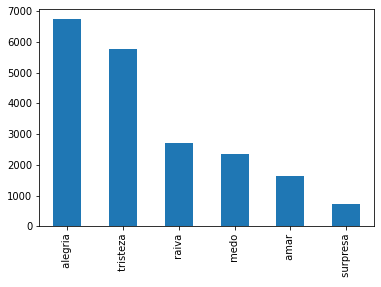

In [80]:
# Analise sobre possível desbalanceamento de classes
%matplotlib inline
df['emocao'].value_counts().plot(kind='bar')

# pyplot.plot(df['emocao'].value_counts())
# pyplot.show()

In [81]:
# aplicando os processos de tratamento nos texto (retirada de pontuação, stopwords, stemmer e lemmatization)
X = [pre_processing(i) for i in df['texto']]

In [114]:
labelencoder = LabelEncoder()
y_train_enco = labelencoder.fit_transform(df['emocao'])

X_train, X_test, y_train, y_test = train_test_split(pd.Series(X), pd.Series(y_train_enco), random_state=41, test_size=0.2, stratify=pd.Series(y_train_enco))

# Com o uso do Undersampler a performce do modelo piora, muito provavelmente devido a grande diminuição de dados
undersample = RandomUnderSampler()
X_under, y_under = undersample.fit_resample(pd.DataFrame(X), pd.Series(y_train_enco))
X_train_under, X_test_under, y_train_under, y_test_under = train_test_split(X_under.squeeze(), y_under, random_state=41, test_size=0.2, stratify=y_under)

In [115]:
type(X_test_under)

pandas.core.series.Series

<AxesSubplot:>

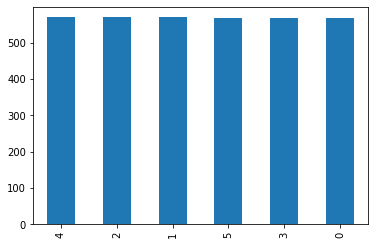

In [116]:
# analisando o resultado da aplicação de undersampler nas classes para ficarem próximas ao da classe minoritária
%matplotlib inline
y_train_under.value_counts().plot(kind='bar')

#### Tokenização - Importante. Por não se tratar de uma análise de dados recuperados da internet, onde existe um linguajar específico onde é usado emoticons, hashtag, emojis e etc, para essa análise não precisamos utilizar o Tokenizer do Tweeter para tratar esse tipo de linguajar. Podemos usar o Tokenizer de palavras normais e entender que o espaço é o suficiente para separar as palavras sem afetar o sentido do textos

#### Frases e Predições de teste

In [117]:
testes = ['eu posso ter para um deleite ou se estou me sentindo festivo',
          'estou me sentindo muito triste e com pena de mim mesma, mas logo vou me livrar disso',
          'estou apenas me sentindo mal-humorada e azul ',
          'só sei que, para começar, vou me sentir tímido com isso',
          'eu também adorei que você pudesse realmente sentir o desespero nessas sequências e eu gostei especialmente da emoção entre cavaleiro e escudeiro, já que eles estão juntos de maneira semelhante a batman e robin há muito tempo',
          'estou me sentindo um pouco atordoada com a quantidade de itens que não uso mais para decoração']

predicao_correta = ['alegria', 'tristeza', 'raiva', 'medo', 'amar', 'surpresa']

In [118]:
testes = [pre_processing(i) for i in testes]

In [119]:
# Transforma os dados de teste em vetores de palavras.
tfidf_vectorizer = TfidfVectorizer()
tfidf_vectorizer.fit(X_train)
texto_teste_vetorizado = tfidf_vectorizer.transform(testes)

#### Vetorização dos textos

*   CountVectorizer: [BagOfWords Model] - É uma representação numérica de uma fração do texto que facilita a classificação, dessa forma o algoritmo conta a frequnência com que a palavra aparece no texto e cria um dicionário disso. Isso é chamado de Tokenization in NLP (Natural Language Processing). O CountVectorizer realiza esse processo
*   TfidfVectorizer: Transforma texto em vetores de recursos que podem ser usados ​​como entrada para o estimador



In [120]:
def get_vectorize_instance(vectorize_name):
    if(vectorize_name == 'CountVectorizer'):
        return CountVectorizer(analyzer="word")
    elif(vectorize_name == 'TfidfVectorizer'):
        return TfidfVectorizer()
    else:
        raise Exception("Vectorizer not found!")

In [121]:
def vectorize_dataframe(vectorizer, X_train, X_test):
    if(type(vectorizer) is CountVectorizer):
        train_data = vectorizer.fit_transform(X_train)
        test_data = vectorizer.transform(X_test)
        return train_data, test_data
    elif (type(vectorizer) is TfidfVectorizer):
        vectorizer.fit(X_train)
        train_data = vectorizer.transform(X_train)
        test_data = vectorizer.transform(X_test)
        return train_data, test_data
    else:
        raise Exception("Vectorizer type incorrect!")

In [122]:
def train_model(modelo, X_train, y_train):
    return modelo.fit(X_train, y_train)

In [123]:
def predict_model(modelo, X_test):
    return modelo.predict(X_test)

In [124]:
def score_model(modelo, X_test, y_test):
    return modelo.score(X_test, y_test)

In [286]:
def plot_predict_right(X_test, predictions, right_predictions, num_rows=5):
    pred = pd.DataFrame({'predição modelo': predictions, 'predição correta': right_predictions})
    display(pred[:num_rows])

In [285]:
def plot_classification_report(y_test, y_pred):
    print(metrics.classification_report(y_test, y_pred))

In [ ]:
def plot_confusion_m()

In [290]:
def evaluates_score_model(modelo, vectorizer, X_train, X_test, y_train, y_test):
    print('#######################################################################################################################################')
    print('##### Avaliando Modelo {} / Vectorizer {} #####'.format(modelo, vectorizer))
    train_vectorized, test_vectorized = vectorize_dataframe(vectorizer, X_train, X_test)
    model = train_model(modelo, train_vectorized, y_train)
    y_pred = predict_model(modelo, test_vectorized)
    print('Accuracy do Modelo {} com Vectorizer {} é de {:.3f}'.format(modelo, vectorizer, float(metrics.accuracy_score(y_test, y_pred))))
    print('Precision do Modelo {} com Vectorizer {} é de {:.3f}'.format(modelo, vectorizer, float(metrics.precision_score(y_test, y_pred, average='macro'))))
    print('Recall do Modelo {} com Vectorizer {} é de {:.3f}'.format(modelo, vectorizer, float(metrics.recall_score(y_test, y_pred, average='macro'))))
    print('F1-Score do Modelo {} com Vectorizer {} é de {:.3f}'.format(modelo, vectorizer, float(metrics.f1_score(y_test, y_pred, average='macro'))))
    plot_predict_right(X_test, y_pred, y_test)
    plot_classification_report(y_test, y_pred)
    print('\n')
    return y_pred

In [ ]:
plot_predict_right(X_test, )

In [128]:
# cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)

# space = dict()
# space['solver'] = ['newton-cg', 'lbfgs', 'liblinear']
# space['penalty'] = ['none', 'l1', 'l2', 'elasticnet']
# space['C'] = loguniform(1e-5, 100)

# search = RandomizedSearchCV(LogisticRegression(), space, n_iter=500, scoring='accuracy', n_jobs=-1, cv=cv, random_state=1)
# # search = GridSearchCV(..., scoring='accuracy', n_jobs=-1)

# train_vectorized, test_vectorized = vectorize_dataframe(get_vectorize_instance('TfidfVectorizer'), X_train, X_test)

# # execute search
# result = search.fit(train_vectorized, y_train)

# # summarize result
# print('Best Score: %s' % result.best_score_)
# print('Best Hyperparameters: %s' % result.best_params_)

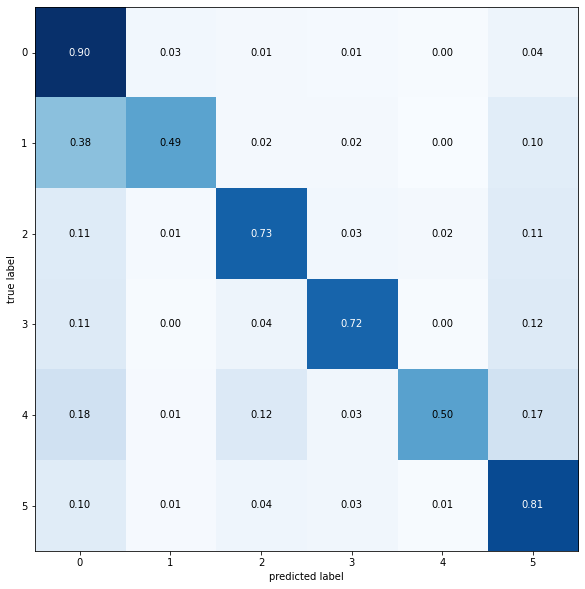

In [182]:
import matplotlib.pyplot as plt
from mlxtend.plotting import plot_confusion_matrix
from mlxtend.evaluate import confusion_matrix

cm = confusion_matrix(y_target=y_test, y_predicted=y_pred_sgd_count_vect, binary=False)

fig, ax = plot_confusion_matrix(conf_mat=cm, show_absolute=False, show_normed=True, figsize= (10, 10))
plt.show()

nome1


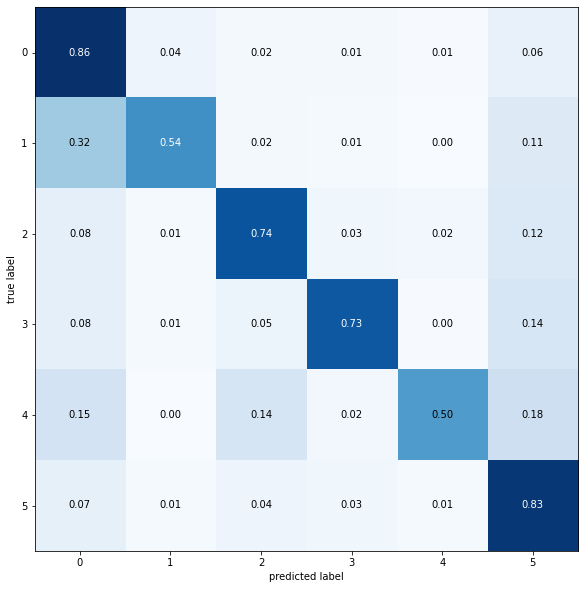

nome2


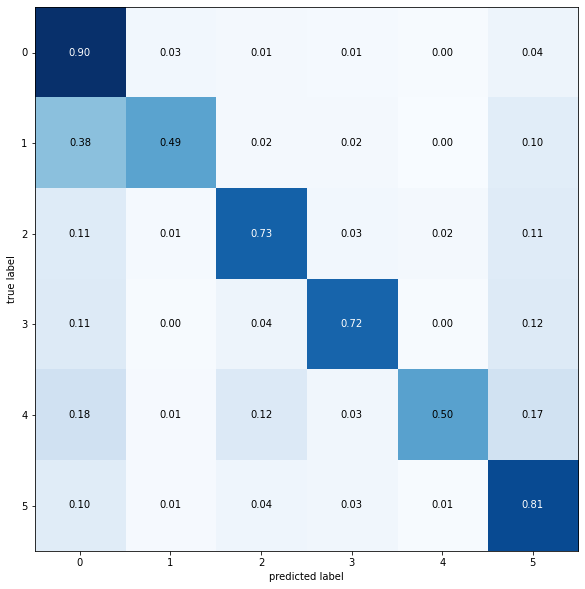

In [194]:
import itertools

for y_pred, name, lab, grd in zip([y_pred_lr_count_vec, y_pred_sgd_count_vect],
                            ['nome1', 'nome2'],
                         y_test,
                         itertools.product([0, 1],
                         repeat=2)):
    
    cm = confusion_matrix(y_target=y_test, y_predicted=y_pred, binary=False)
    print(name)
    fig, ax = plot_confusion_matrix(conf_mat=cm, show_absolute=False, show_normed=True, figsize= (10, 10))
    plt.show()

[[1154   57   27   19    8   82]
 [ 103  176    5    4    1   37]
 [  37    6  349   15   10   56]
 [  42    6   25  392    2   73]
 [  22    0   20    3   71   26]
 [  85   13   48   37   12  961]]
AxesSubplot(0.125,0.125;0.775x0.755)
[[1213   37   19   15    5   58]
 [ 123  161    5    6    0   31]
 [  52    5  346   12    8   50]
 [  61    2   23  389    2   63]
 [  25    1   17    4   71   24]
 [ 119   12   48   36    7  934]]
AxesSubplot(0.125,0.125;0.775x0.755)


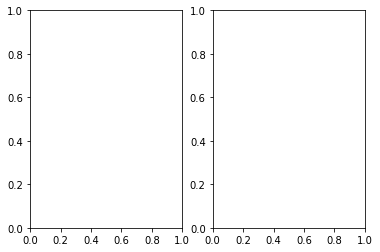

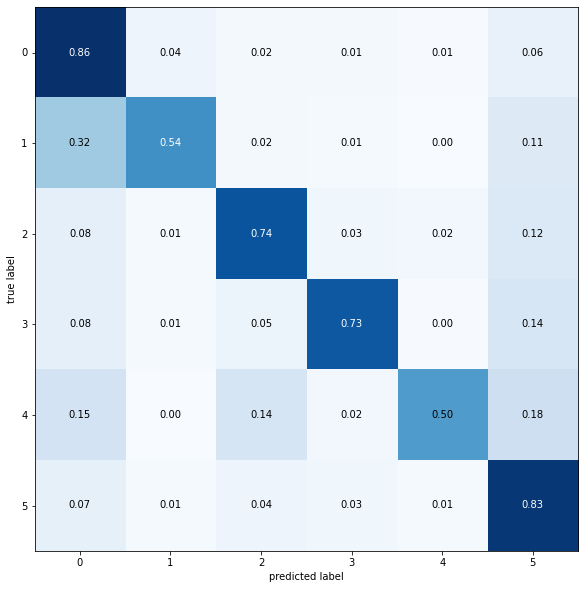

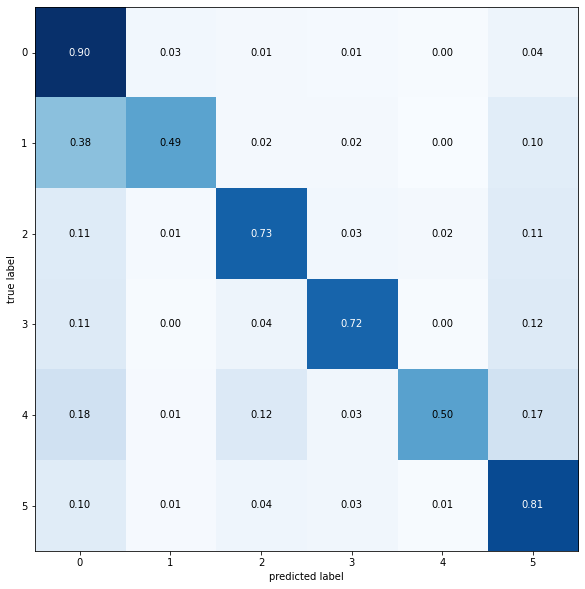

In [197]:
from sklearn.metrics import plot_confusion_matrix

fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(15,10))

for cls, ax in zip(classifiers, axes.flatten()):

for y_pred, name, lab, grd in zip([y_pred_lr_count_vec, y_pred_sgd_count_vect],
                            ['nome1', 'nome2'], 
                         y_test,
                         itertools.product([0, 1],
                         repeat=2)):
    
        cm = confusion_matrix(y_target=y_test, y_predicted=y_pred, binary=False)
        print(name)
        fig, ax = plot_confusion_matrix(conf_mat=cm, show_absolute=False, show_normed=True, figsize= (10, 10))
    
    plot_confusion_matrix(cls, 
                          X_test, 
                          y_test, 
                          ax=ax, 
                          cmap='Blues',
                         display_labels=data.target_names)
    ax.title.set_text(type(cls).__name__)
plt.tight_layout()  
plt.show()

In [244]:
def get_model_instace(model):
    return {
        'LogisticRegression': LogisticRegression(multi_class='multinomial', solver='lbfgs'),
        'MultinomialNB': MultinomialNB(),
        'RandomForestClassifier': RandomForestClassifier(n_estimators=100),
        'SVC': SVC(kernel='linear'),
        'SGDClassifier': SGDClassifier(loss="log", penalty="l2"),
        'DecisionTreeClassifier': DecisionTreeClassifier(criterion="gini"),
        'KNeighborsClassifier': KNeighborsClassifier(n_neighbors=5),
        'GradientBoostingClassifier': GradientBoostingClassifier(n_estimators=150),
    }.get(model) 

In [291]:
list_models = [get_model_instace('LogisticRegression')
                ,get_model_instace('MultinomialNB')
                ,get_model_instace('RandomForestClassifier')
                ,get_model_instace('SVC')
                ,get_model_instace('SGDClassifier')
                ,get_model_instace('DecisionTreeClassifier')
                ,get_model_instace('KNeighborsClassifier')
                ,get_model_instace('GradientBoostingClassifier')]

list_vectors_instance = [get_vectorize_instance('CountVectorizer'), get_vectorize_instance('TfidfVectorizer')]

for m in list_models:
    for vec in list_vectors_instance:
        y_pred = evaluates_score_model(m, vec, X_train_under, X_test_under, y_train_under, y_test_under)

print('Fim avaliação')

#######################################################################################################################################
##### Avaliando Modelo LogisticRegression(multi_class='multinomial') / Vectorizer CountVectorizer() #####
Accuracy do Modelo LogisticRegression(multi_class='multinomial') com Vectorizer CountVectorizer() é de 0.710
Precision do Modelo LogisticRegression(multi_class='multinomial') com Vectorizer CountVectorizer() é de 0.710
Recall do Modelo LogisticRegression(multi_class='multinomial') com Vectorizer CountVectorizer() é de 0.710
F1-Score do Modelo LogisticRegression(multi_class='multinomial') com Vectorizer CountVectorizer() é de 0.708


C:\Users\wills\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


,predição modelo,predição correta
1172,1,1
3407,4,4
1552,5,2
334,0,0
3321,1,4


              precision    recall  f1-score   support

           0       0.62      0.64      0.63       143
           1       0.68      0.73      0.70       142
           2       0.77      0.69      0.73       142
           3       0.70      0.72      0.71       143
           4       0.81      0.89      0.85       142
           5       0.69      0.59      0.64       143

    accuracy                           0.71       855
   macro avg       0.71      0.71      0.71       855
weighted avg       0.71      0.71      0.71       855



#######################################################################################################################################
##### Avaliando Modelo LogisticRegression(multi_class='multinomial') / Vectorizer TfidfVectorizer() #####
Accuracy do Modelo LogisticRegression(multi_class='multinomial') com Vectorizer TfidfVectorizer() é de 0.705
Precision do Modelo LogisticRegression(multi_class='multinomial') com Vectorizer TfidfVectorizer() é de 

,predição modelo,predição correta
1172,1,1
3407,4,4
1552,5,2
334,0,0
3321,1,4


              precision    recall  f1-score   support

           0       0.61      0.63      0.62       143
           1       0.65      0.75      0.70       142
           2       0.76      0.68      0.72       142
           3       0.73      0.72      0.72       143
           4       0.79      0.87      0.83       142
           5       0.69      0.57      0.63       143

    accuracy                           0.71       855
   macro avg       0.71      0.71      0.70       855
weighted avg       0.71      0.71      0.70       855



#######################################################################################################################################
##### Avaliando Modelo MultinomialNB() / Vectorizer CountVectorizer() #####
Accuracy do Modelo MultinomialNB() com Vectorizer CountVectorizer() é de 0.642
Precision do Modelo MultinomialNB() com Vectorizer CountVectorizer() é de 0.643
Recall do Modelo MultinomialNB() com Vectorizer CountVectorizer() é de 0.642
F1-Scor

,predição modelo,predição correta
1172,1,1
3407,4,4
1552,2,2
334,0,0
3321,1,4


              precision    recall  f1-score   support

           0       0.63      0.53      0.58       143
           1       0.56      0.67      0.61       142
           2       0.73      0.66      0.69       142
           3       0.64      0.67      0.66       143
           4       0.69      0.83      0.75       142
           5       0.60      0.49      0.54       143

    accuracy                           0.64       855
   macro avg       0.64      0.64      0.64       855
weighted avg       0.64      0.64      0.64       855



#######################################################################################################################################
##### Avaliando Modelo MultinomialNB() / Vectorizer TfidfVectorizer() #####
Accuracy do Modelo MultinomialNB() com Vectorizer TfidfVectorizer() é de 0.673
Precision do Modelo MultinomialNB() com Vectorizer TfidfVectorizer() é de 0.675
Recall do Modelo MultinomialNB() com Vectorizer TfidfVectorizer() é de 0.673
F1-Scor

,predição modelo,predição correta
1172,1,1
3407,4,4
1552,2,2
334,0,0
3321,4,4


              precision    recall  f1-score   support

           0       0.66      0.59      0.63       143
           1       0.59      0.70      0.64       142
           2       0.72      0.65      0.69       142
           3       0.71      0.70      0.70       143
           4       0.70      0.87      0.78       142
           5       0.67      0.52      0.58       143

    accuracy                           0.67       855
   macro avg       0.67      0.67      0.67       855
weighted avg       0.67      0.67      0.67       855



#######################################################################################################################################
##### Avaliando Modelo RandomForestClassifier() / Vectorizer CountVectorizer() #####
Accuracy do Modelo RandomForestClassifier() com Vectorizer CountVectorizer() é de 0.710
Precision do Modelo RandomForestClassifier() com Vectorizer CountVectorizer() é de 0.709
Recall do Modelo RandomForestClassifier() com Vectorizer 

,predição modelo,predição correta
1172,1,1
3407,4,4
1552,2,2
334,0,0
3321,4,4


              precision    recall  f1-score   support

           0       0.61      0.57      0.59       143
           1       0.69      0.77      0.73       142
           2       0.79      0.73      0.75       142
           3       0.71      0.71      0.71       143
           4       0.82      0.88      0.85       142
           5       0.63      0.61      0.62       143

    accuracy                           0.71       855
   macro avg       0.71      0.71      0.71       855
weighted avg       0.71      0.71      0.71       855



#######################################################################################################################################
##### Avaliando Modelo RandomForestClassifier() / Vectorizer TfidfVectorizer() #####
Accuracy do Modelo RandomForestClassifier() com Vectorizer TfidfVectorizer() é de 0.685
Precision do Modelo RandomForestClassifier() com Vectorizer TfidfVectorizer() é de 0.683
Recall do Modelo RandomForestClassifier() com Vectorizer 

,predição modelo,predição correta
1172,1,1
3407,4,4
1552,5,2
334,0,0
3321,4,4


              precision    recall  f1-score   support

           0       0.52      0.50      0.51       143
           1       0.69      0.77      0.72       142
           2       0.80      0.70      0.75       142
           3       0.70      0.69      0.69       143
           4       0.82      0.91      0.86       142
           5       0.58      0.55      0.56       143

    accuracy                           0.69       855
   macro avg       0.68      0.69      0.68       855
weighted avg       0.68      0.69      0.68       855



#######################################################################################################################################
##### Avaliando Modelo SVC(kernel='linear') / Vectorizer CountVectorizer() #####
Accuracy do Modelo SVC(kernel='linear') com Vectorizer CountVectorizer() é de 0.695
Precision do Modelo SVC(kernel='linear') com Vectorizer CountVectorizer() é de 0.698
Recall do Modelo SVC(kernel='linear') com Vectorizer CountVectorizer(

,predição modelo,predição correta
1172,1,1
3407,4,4
1552,5,2
334,0,0
3321,0,4


              precision    recall  f1-score   support

           0       0.58      0.64      0.61       143
           1       0.65      0.75      0.70       142
           2       0.76      0.67      0.71       142
           3       0.68      0.69      0.69       143
           4       0.81      0.88      0.84       142
           5       0.71      0.55      0.62       143

    accuracy                           0.69       855
   macro avg       0.70      0.69      0.69       855
weighted avg       0.70      0.69      0.69       855



#######################################################################################################################################
##### Avaliando Modelo SVC(kernel='linear') / Vectorizer TfidfVectorizer() #####
Accuracy do Modelo SVC(kernel='linear') com Vectorizer TfidfVectorizer() é de 0.708
Precision do Modelo SVC(kernel='linear') com Vectorizer TfidfVectorizer() é de 0.713
Recall do Modelo SVC(kernel='linear') com Vectorizer TfidfVectorizer(

,predição modelo,predição correta
1172,1,1
3407,4,4
1552,2,2
334,5,0
3321,1,4


              precision    recall  f1-score   support

           0       0.57      0.67      0.62       143
           1       0.66      0.71      0.68       142
           2       0.80      0.68      0.73       142
           3       0.72      0.69      0.70       143
           4       0.83      0.88      0.86       142
           5       0.70      0.61      0.65       143

    accuracy                           0.71       855
   macro avg       0.71      0.71      0.71       855
weighted avg       0.71      0.71      0.71       855



#######################################################################################################################################
##### Avaliando Modelo SGDClassifier(loss='log') / Vectorizer CountVectorizer() #####
Accuracy do Modelo SGDClassifier(loss='log') com Vectorizer CountVectorizer() é de 0.724
Precision do Modelo SGDClassifier(loss='log') com Vectorizer CountVectorizer() é de 0.726
Recall do Modelo SGDClassifier(loss='log') com Vectori

,predição modelo,predição correta
1172,1,1
3407,4,4
1552,2,2
334,0,0
3321,1,4


              precision    recall  f1-score   support

           0       0.70      0.58      0.64       143
           1       0.64      0.78      0.70       142
           2       0.77      0.70      0.74       142
           3       0.73      0.73      0.73       143
           4       0.79      0.89      0.83       142
           5       0.72      0.66      0.69       143

    accuracy                           0.72       855
   macro avg       0.73      0.72      0.72       855
weighted avg       0.73      0.72      0.72       855



#######################################################################################################################################
##### Avaliando Modelo SGDClassifier(loss='log') / Vectorizer TfidfVectorizer() #####
Accuracy do Modelo SGDClassifier(loss='log') com Vectorizer TfidfVectorizer() é de 0.730
Precision do Modelo SGDClassifier(loss='log') com Vectorizer TfidfVectorizer() é de 0.731
Recall do Modelo SGDClassifier(loss='log') com Vectori

,predição modelo,predição correta
1172,1,1
3407,4,4
1552,5,2
334,0,0
3321,1,4


              precision    recall  f1-score   support

           0       0.65      0.64      0.65       143
           1       0.67      0.76      0.71       142
           2       0.80      0.72      0.76       142
           3       0.74      0.75      0.74       143
           4       0.80      0.89      0.84       142
           5       0.73      0.62      0.67       143

    accuracy                           0.73       855
   macro avg       0.73      0.73      0.73       855
weighted avg       0.73      0.73      0.73       855



#######################################################################################################################################
##### Avaliando Modelo DecisionTreeClassifier() / Vectorizer CountVectorizer() #####
Accuracy do Modelo DecisionTreeClassifier() com Vectorizer CountVectorizer() é de 0.635
Precision do Modelo DecisionTreeClassifier() com Vectorizer CountVectorizer() é de 0.637
Recall do Modelo DecisionTreeClassifier() com Vectorizer 

,predição modelo,predição correta
1172,1,1
3407,4,4
1552,0,2
334,0,0
3321,4,4


              precision    recall  f1-score   support

           0       0.45      0.43      0.44       143
           1       0.62      0.70      0.66       142
           2       0.74      0.68      0.71       142
           3       0.65      0.67      0.66       143
           4       0.86      0.83      0.85       142
           5       0.50      0.51      0.51       143

    accuracy                           0.64       855
   macro avg       0.64      0.64      0.64       855
weighted avg       0.64      0.64      0.64       855



#######################################################################################################################################
##### Avaliando Modelo DecisionTreeClassifier() / Vectorizer TfidfVectorizer() #####
Accuracy do Modelo DecisionTreeClassifier() com Vectorizer TfidfVectorizer() é de 0.607
Precision do Modelo DecisionTreeClassifier() com Vectorizer TfidfVectorizer() é de 0.612
Recall do Modelo DecisionTreeClassifier() com Vectorizer 

,predição modelo,predição correta
1172,1,1
3407,4,4
1552,5,2
334,5,0
3321,4,4


              precision    recall  f1-score   support

           0       0.38      0.42      0.40       143
           1       0.58      0.64      0.61       142
           2       0.71      0.68      0.70       142
           3       0.66      0.62      0.64       143
           4       0.86      0.84      0.85       142
           5       0.49      0.45      0.47       143

    accuracy                           0.61       855
   macro avg       0.61      0.61      0.61       855
weighted avg       0.61      0.61      0.61       855



#######################################################################################################################################
##### Avaliando Modelo KNeighborsClassifier() / Vectorizer CountVectorizer() #####
Accuracy do Modelo KNeighborsClassifier() com Vectorizer CountVectorizer() é de 0.320
Precision do Modelo KNeighborsClassifier() com Vectorizer CountVectorizer() é de 0.333
Recall do Modelo KNeighborsClassifier() com Vectorizer CountVec

,predição modelo,predição correta
1172,2,1
3407,0,4
1552,0,2
334,4,0
3321,3,4


              precision    recall  f1-score   support

           0       0.25      0.40      0.31       143
           1       0.42      0.30      0.35       142
           2       0.38      0.39      0.39       142
           3       0.26      0.28      0.27       143
           4       0.40      0.35      0.37       142
           5       0.28      0.21      0.24       143

    accuracy                           0.32       855
   macro avg       0.33      0.32      0.32       855
weighted avg       0.33      0.32      0.32       855



#######################################################################################################################################
##### Avaliando Modelo KNeighborsClassifier() / Vectorizer TfidfVectorizer() #####
Accuracy do Modelo KNeighborsClassifier() com Vectorizer TfidfVectorizer() é de 0.570
Precision do Modelo KNeighborsClassifier() com Vectorizer TfidfVectorizer() é de 0.580
Recall do Modelo KNeighborsClassifier() com Vectorizer TfidfVec

,predição modelo,predição correta
1172,1,1
3407,4,4
1552,2,2
334,0,0
3321,4,4


              precision    recall  f1-score   support

           0       0.47      0.62      0.53       143
           1       0.57      0.58      0.58       142
           2       0.58      0.65      0.61       142
           3       0.60      0.56      0.58       143
           4       0.61      0.58      0.60       142
           5       0.66      0.43      0.52       143

    accuracy                           0.57       855
   macro avg       0.58      0.57      0.57       855
weighted avg       0.58      0.57      0.57       855



#######################################################################################################################################
##### Avaliando Modelo GradientBoostingClassifier(n_estimators=150) / Vectorizer CountVectorizer() #####
Accuracy do Modelo GradientBoostingClassifier(n_estimators=150) com Vectorizer CountVectorizer() é de 0.766
Precision do Modelo GradientBoostingClassifier(n_estimators=150) com Vectorizer CountVectorizer() é de 0.7

,predição modelo,predição correta
1172,1,1
3407,4,4
1552,2,2
334,0,0
3321,1,4


              precision    recall  f1-score   support

           0       0.69      0.62      0.65       143
           1       0.75      0.77      0.76       142
           2       0.89      0.77      0.82       142
           3       0.85      0.76      0.80       143
           4       0.83      0.91      0.87       142
           5       0.63      0.78      0.70       143

    accuracy                           0.77       855
   macro avg       0.77      0.77      0.77       855
weighted avg       0.77      0.77      0.77       855



#######################################################################################################################################
##### Avaliando Modelo GradientBoostingClassifier(n_estimators=150) / Vectorizer TfidfVectorizer() #####
Accuracy do Modelo GradientBoostingClassifier(n_estimators=150) com Vectorizer TfidfVectorizer() é de 0.729
Precision do Modelo GradientBoostingClassifier(n_estimators=150) com Vectorizer TfidfVectorizer() é de 0.7

,predição modelo,predição correta
1172,1,1
3407,4,4
1552,2,2
334,0,0
3321,1,4


              precision    recall  f1-score   support

           0       0.64      0.57      0.60       143
           1       0.72      0.70      0.71       142
           2       0.90      0.72      0.80       142
           3       0.82      0.75      0.78       143
           4       0.81      0.90      0.85       142
           5       0.56      0.73      0.63       143

    accuracy                           0.73       855
   macro avg       0.74      0.73      0.73       855
weighted avg       0.74      0.73      0.73       855



Fim avaliação
